<a href="https://colab.research.google.com/github/rickyhndrwn/tubes_tkc-18_247-18_249/blob/main/Tugas%206%20-%20Tubes%20CBIR/cbir_project_18_247_18_249.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CBIR Project - Temu Kembali Citra 7B
---
NIM - Nama = 201810370311247 - Ricky Hendrawan

NIM - Nama = 201810370311249 - Shofiyah

### Import library

In [31]:
import os

import cv2
import numpy as np

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, InputLayer, MaxPool2D, SeparableConv2D

from tensorflow.keras.metrics import Precision, Recall

import json

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

from keras.preprocessing.image import load_img, img_to_array

import time

### Define path

In [2]:
base_dir = '/content/drive/MyDrive/Dataset/chest_xray'

splitted_dir = os.path.join(base_dir, 'splitted_data')

train_dir = os.path.join(splitted_dir, 'train')
norm_train_dir = os.path.join(train_dir, 'normal')
pneu_train_dir = os.path.join(train_dir, 'pneumonia')

val_dir = os.path.join(splitted_dir, 'val')
norm_val_dir = os.path.join(val_dir, 'normal')
pneu_val_dir = os.path.join(val_dir, 'pneumonia')

test_dir = os.path.join(splitted_dir, 'test')
norm_test_dir = os.path.join(test_dir, 'normal')
pneu_test_dir = os.path.join(test_dir, 'pneumonia')

In [3]:
print("Total Training NORMAL:", len(os.listdir(norm_train_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_train_dir)))
print('-'*30)
print("Total validation NORMAL:", len(os.listdir(norm_val_dir)))
print("Total validation PNEUMONIA:", len(os.listdir(pneu_val_dir)))
print('-'*30)
print("Total Testing NORMAL:", len(os.listdir(norm_test_dir)))
print("Total Testing PNEUMONIA:", len(os.listdir(pneu_test_dir)))

Total Training NORMAL: 1266
Total Training PNEUMONIA: 3418
------------------------------
Total validation NORMAL: 300
Total validation PNEUMONIA: 811
------------------------------
Total Testing NORMAL: 17
Total Testing PNEUMONIA: 44


### Check data split ratio

In [10]:
total_train_data = len(os.listdir(norm_train_dir)) + len(os.listdir(pneu_train_dir))
total_val_data = len(os.listdir(norm_val_dir)) + len(os.listdir(pneu_val_dir))
total_test_data = len(os.listdir(norm_test_dir)) + len(os.listdir(pneu_test_dir))

total_data = total_train_data + total_val_data + total_test_data

print(f"Rasio data train = {(total_train_data / total_data) * 100:.2f} %")
print(f"Rasio data val = {(total_val_data / total_data) * 100:.2f} %")
print(f"Rasio data test = {(total_test_data / total_data) * 100:.2f} %")

Rasio data train = 79.99 %
Rasio data val = 18.97 %
Rasio data test = 1.04 %


### Gather data

In [11]:
"""
Fungsi untuk gather data,
Menerima 1 parameter berupa direktori data,
Return 2 list
"""
def gather_data(data_dir):
    dir_data = []
    dir_label = []

    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:
            if ".jpeg" in file:
                image_path = os.path.join(dirpath, file)

                image = cv2.imread(image_path)
                image = cv2.resize(image, (180,180))
                image = image.astype('float32') / 255.0
                dir_data.append(image)

                label = int((image_path.split(os.path.sep)[-2]) == 'pneumonia')
                dir_label.append(label)

    dir_data = np.array(dir_data)
    dir_label = np.array(dir_label)

    return dir_data, dir_label

In [12]:
# Gather data train
x_train, y_train = gather_data(train_dir)
# Gather data val
x_val, y_val = gather_data(val_dir)
# Gather data test
x_test, y_test = gather_data(test_dir)

### Save gathered data

In [13]:
data_label_save_dir = '/content/drive/MyDrive/Colab Notebooks/Tugas Kelompok Praktikum PM 2021/Preprocessed Data/Gather Func Only'

preprocessed_data = [x_train, y_train, x_test, y_test, x_val, y_val]
preprocessed_file_name = ['x_train', 'y_train', 'x_test', 'y_test', 'x_val', 'y_val']
for i, file_name in enumerate(preprocessed_file_name):
    np.save(data_label_save_dir + '/' + file_name + '.npy', preprocessed_data[i])

### Load gathered data

In [14]:
data_label_save_dir = '/content/drive/MyDrive/Colab Notebooks/Tugas Kelompok Praktikum PM 2021/Preprocessed Data/Gather Func Only'

x_train = np.load(data_label_save_dir + '/x_train.npy')
x_val = np.load(data_label_save_dir + '/x_val.npy')
x_test = np.load(data_label_save_dir + '/x_test.npy')

y_train = np.load(data_label_save_dir + '/y_train.npy')
y_val = np.load(data_label_save_dir + '/y_val.npy')
y_test = np.load(data_label_save_dir + '/y_test.npy')

### Print data shape

In [15]:
print("Train Data = ", x_train.shape)
print("Train Label = ", y_train.shape)
print('-'*30)
print("Val Data = ", x_val.shape)
print("Val Label = ", y_val.shape)
print('-'*30)
print("Test Data = ", x_test.shape)
print("Test Label = ", y_test.shape)

Train Data =  (4684, 180, 180, 3)
Train Label =  (4684,)
------------------------------
Val Data =  (1111, 180, 180, 3)
Val Label =  (1111,)
------------------------------
Test Data =  (61, 180, 180, 3)
Test Label =  (61,)


### Class weighting

In [16]:
norm_dir = os.path.join(base_dir, 'normal')
pneu_dir = os.path.join(base_dir, 'pneumonia')

norm_data_count = len(os.listdir(norm_dir))
pneu_data_count = len(os.listdir(pneu_dir))

print(f"Jumlah Normal: {norm_data_count}\nJumlah Pneoumonia: {pneu_data_count}")

Jumlah Normal: 1583
Jumlah Pneoumonia: 4273


In [17]:
weight_for_0 = (1 / norm_data_count) * (x_train.shape[0]) / 2.0 
weight_for_1 = (1 / pneu_data_count) * (x_train.shape[0]) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.48
Weight for class 1: 0.55


### Modelling

In [18]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = Sequential([
        Input(shape=(180, 180, 3)),

        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        Dropout(0.2),
        
        conv_block(256),
        
        Dropout(0.2),
        Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

### Phase 1 model training

In [21]:
model = build_model()

METRICS = [
    'acc',
    Precision(name='precision'),
    Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [22]:
TRAIN_IMG_COUNT = x_train.shape[0]
VAL_IMG_COUNT = x_val.shape[0]
BATCH_SIZE = 128

In [23]:
H = model.fit(x_train, y_train,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=25,
              validation_data=(x_val, y_val),
              validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
              class_weight=class_weight,
              )

Epoch 1/25
36/36 [==============================] - 335s 9s/step - loss: 0.4497 - acc: 0.7299 - precision: 0.9207 - recall: 0.6893 - val_loss: 0.6399 - val_acc: 0.7300 - val_precision: 0.7300 - val_recall: 1.0000
Epoch 2/25
36/36 [==============================] - 328s 9s/step - loss: 0.2841 - acc: 0.8484 - precision: 0.9605 - recall: 0.8262 - val_loss: 0.5846 - val_acc: 0.7300 - val_precision: 0.7300 - val_recall: 1.0000
Epoch 3/25
36/36 [==============================] - 329s 9s/step - loss: 0.2077 - acc: 0.9003 - precision: 0.9713 - recall: 0.8897 - val_loss: 0.6367 - val_acc: 0.7300 - val_precision: 0.7300 - val_recall: 1.0000
Epoch 4/25
36/36 [==============================] - 328s 9s/step - loss: 0.1724 - acc: 0.9172 - precision: 0.9708 - recall: 0.9140 - val_loss: 0.7264 - val_acc: 0.7300 - val_precision: 0.7300 - val_recall: 1.0000
Epoch 5/25
36/36 [==============================] - 328s 9s/step - loss: 0.1547 - acc: 0.9257 - precision: 0.9720 - recall: 0.9248 - val_loss: 0.786

### Save history, model, and model's weight

In [24]:
target_dir = '/content/drive/MyDrive/Informatika/Semester 7/Temu Kembali Citra/CBIR Project - Temu Kembali Citra 7B'

history_dict = H.history
json.dump(history_dict, open(target_dir + '/phase_1_train_model_history.json', 'w'))

model.save(target_dir + '/phase_1_train_model.h5')
model.save_weights(target_dir + '/phase_1_train_model_weights.h5')

### Phase 1 Plot graph
---
Precision, recall, accuracy, loss

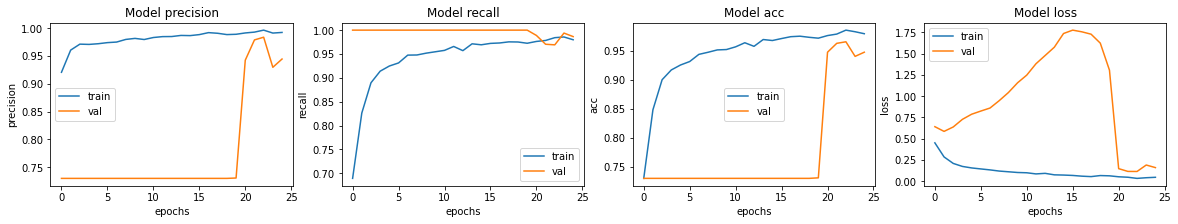

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'acc', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Finetune model

In [30]:
save_dir = target_dir

checkpoint_cb = ModelCheckpoint(save_dir + "/xray_model.h5",
                                save_best_only=True)

early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True)

In [32]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

### Phase 2 model training

In [33]:
H = model.fit(x_train, y_train,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=100,
              validation_data=(x_val, y_val),
              validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
              class_weight=class_weight,
              callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
              )

Epoch 1/100
36/36 [==============================] - 328s 9s/step - loss: 0.2179 - acc: 0.8911 - precision: 0.9625 - recall: 0.8853 - val_loss: 1847.9469 - val_acc: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/100
36/36 [==============================] - 326s 9s/step - loss: 0.1622 - acc: 0.9231 - precision: 0.9705 - recall: 0.9228 - val_loss: 124.3745 - val_acc: 0.2718 - val_precision: 1.0000 - val_recall: 0.0025 - lr: 0.0089
Epoch 3/100
36/36 [==============================] - 326s 9s/step - loss: 0.1317 - acc: 0.9377 - precision: 0.9748 - recall: 0.9389 - val_loss: 9.4643 - val_acc: 0.4131 - val_precision: 1.0000 - val_recall: 0.1961 - lr: 0.0079
Epoch 4/100
36/36 [==============================] - 326s 9s/step - loss: 0.1178 - acc: 0.9428 - precision: 0.9814 - recall: 0.9394 - val_loss: 1.7011 - val_acc: 0.7525 - val_precision: 0.9926 - val_recall: 0.6658 - lr: 0.0071
Epoch 5/100
36/36 [==============================] - 325s 9s/step - loss: 0.108

### Save history and model's weight

In [34]:
target_dir = '/content/drive/MyDrive/Informatika/Semester 7/Temu Kembali Citra/CBIR Project - Temu Kembali Citra 7B'

history_dict = str(H.history)
json.dump(history_dict, open(target_dir + '/phase_2_train_model_history.json', 'w'))

model.save_weights(target_dir + '/phase_2_train_model_weights.h5')

### Phase 2 Plot graph
---
Precision, recall, accuracy, loss

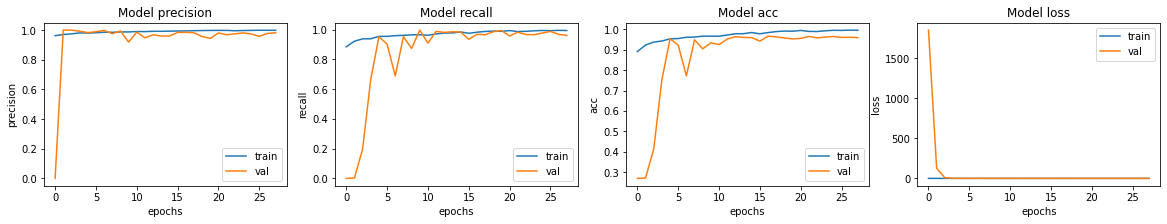

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'acc', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model evaluation

In [38]:
loss, acc, prec, rec = model.evaluate(x_test, y_test)
print(f"Loss = {loss * 100:.2f} %")
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

2/2 [==============================] - 1s 479ms/step - loss: 0.1497 - acc: 0.9344 - precision: 0.9762 - recall: 0.9318
Loss = 14.97 %
Accuracy = 93.44 %
Precision = 97.62 %
Recall = 93.18 %


#### Classificaion report

In [39]:
pred = model.predict(x_test)
y_pred = (pred > 0.5).astype(np.int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.98      0.93      0.95        44

    accuracy                           0.93        61
   macro avg       0.91      0.94      0.92        61
weighted avg       0.94      0.93      0.94        61



#### Confusion matrix

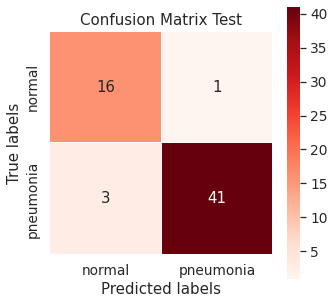

In [44]:
labels = ['normal', 'pneumonia']

cmatrix_result = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
ax = plt.subplot()

data = np.asarray(cmatrix_result).reshape(2,2)

sns.set(font_scale=1.25)
sns.heatmap(data,
            annot=True,
            ax=ax,
            cmap=plt.cm.Reds,
            square=True,
            linewidths=.5,
            xticklabels=labels, yticklabels=labels
            )

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.title('Confusion Matrix Test')
plt.show()